In [358]:
import numpy as np
import matplotlib.pyplot as plt

In [359]:
K = 10
TRIALS = 1000
ITERATIONS = 2000
MEAN_MEAN = 0
MEAN_STDDEV = 1
SAMPLE_STDDEV = 1
MEANS = np.random.normal(MEAN_MEAN, MEAN_STDDEV, K)
DATA = np.array([np.random.normal(mu, SAMPLE_STDDEV, TRIALS) for mu in MEANS])
EPSILON = 0.1

In [360]:
print(MEANS)
print(np.mean(DATA, axis=1))

[-0.24059803  0.08535319  0.18693816  1.08047828  1.21759897  1.70530423
 -0.886154    0.86109366  0.10833658 -0.57883476]
[-0.23266382  0.05580049  0.14400212  1.12892681  1.22557471  1.69892046
 -0.9187254   0.87168865  0.09954328 -0.52385953]


In [363]:
class Env:
    def __init__(self, data, true_means, step=0):
        self.data = data
        self.true_means = true_means
        self.length = data.shape[1]
        self.step = step

class Bandit:
    def __init__(self, k, env, epsilon=None, ucb=None, gradient=None, init_estimates=0, iters=2000):
        self.k = k
        self.env = env
        self.epsilon = epsilon
        self.ucb = ucb
        self.gradient = gradient
        self.init_estimates = init_estimates
        self.iters = iters
        self.counts = np.zeros(k)
        self.estimates = np.full(self.k, self.init_estimates, dtype=float)
        self.avg = np.zeros(env.length, dtype=float)
        self.opt = np.zeros(env.length, dtype=float)
    
    def select(self):
        if self.epsilon is not None:
            x = np.random.random()
            if x > self.epsilon:
                return np.argmax(self.estimates)
            else:
                return np.random.randint(0, self.k)

        if self.ucb:
            return np.argmax(self.estimates + self.ucb*np.sqrt(np.log(1 + self.env.step) / (self.counts + 1e-5)))
        
        if self.gradient:
            return 0            
#test
    def act(self):
        index = self.select()
        reward = self.env.data[index, self.env.step]
        n = self.counts[index]
        mean = self.estimates[index]
        self.counts[index] += 1
        self.estimates[index] = (n*mean + reward)/(n+1)
        if self.env.step == 0:
            self.avg[self.env.step] = reward
            if index == np.argmax(self.env.true_means):
                self.opt[self.env.step] = 1
            else:
                self.opt[self.env.step] = 0
        else:
            self.avg[self.env.step] = (self.env.step * self.avg[self.env.step-1] + reward)/(self.env.step + 1)
            if index == np.argmax(self.env.true_means):
                self.opt[self.env.step] = (self.env.step * self.opt[self.env.step-1] + 1)/(self.env.step + 1)
            else:
                self.opt[self.env.step] = (self.env.step * self.opt[self.env.step-1])/(self.env.step + 1)
        self.env.step += 1
        
    def reset(self):
        self.counts = np.zeros(self.k)
        self.estimates = np.full(self.k, self.init_estimates, dtype=float)
        self.avg = np.zeros(self.env.length)
        self.opt = np.zeros(self.env.length)
        self.env.step = 0
        
    def run(self):
        avg = np.zeros((self.iters, self.env.length))
        opt = np.zeros((self.iters, self.env.length))
        for i in range(self.iters):
            for j in range(self.env.length):
                self.act()
                avg[i, j] = self.avg[j]
                opt[i, j] = self.opt[j]
            self.reset()
        avg = np.mean(avg, axis=0)
        opt = np.mean(opt, axis=0)
        return avg, opt

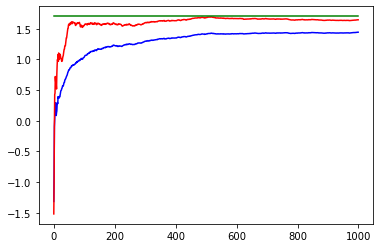

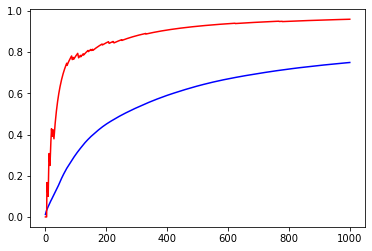

In [364]:
env = Env(DATA, MEANS)
bandit1 = Bandit(K, env, epsilon=EPSILON, init_estimates=0, iters=ITERATIONS)
avg1, opt1 = bandit1.run()
plt.plot(avg1, color='blue')

bandit2 = Bandit(K, env, ucb=1, init_estimates=0, iters=ITERATIONS)
avg2, opt2 = bandit2.run()
plt.plot(avg2, color='red')
plt.plot(np.full(TRIALS, np.max(MEANS)), color='green')
plt.show()

plt.plot(opt1, color='blue')
plt.plot(opt2, color='red')
plt.show()